In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Load and preprocess the dataset
url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv'
df = pd.read_csv(url)
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [3]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [4]:
# Prepare data for LSTM model
look_back = 60  # Number of timesteps to look back
X, y = [], []
for i in range(len(scaled_data) - look_back):
    X.append(scaled_data[i:(i + look_back), 0])
    y.append(scaled_data[i + look_back, 0])
X, y = np.array(X), np.array(y)

In [5]:
# Reshape data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [6]:
# Split data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [7]:
# Build Stacked LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))


c:\python 3.12\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0353
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0014
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0013
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0015
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0010
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0012
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0012
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 8.5438e-04
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 9.5799e-04
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 8.3492e-04
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 9.3942e-04
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 8.6189e-04
Epoch 13/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 7.5934e-04
Epoch 14/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 7.2410e-04
Epoch 15/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 5

In [10]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss}, Test Loss: {test_loss}")

Train Loss: 0.00021559547167271376, Test Loss: 0.00018575810827314854


In [11]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [12]:
# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)


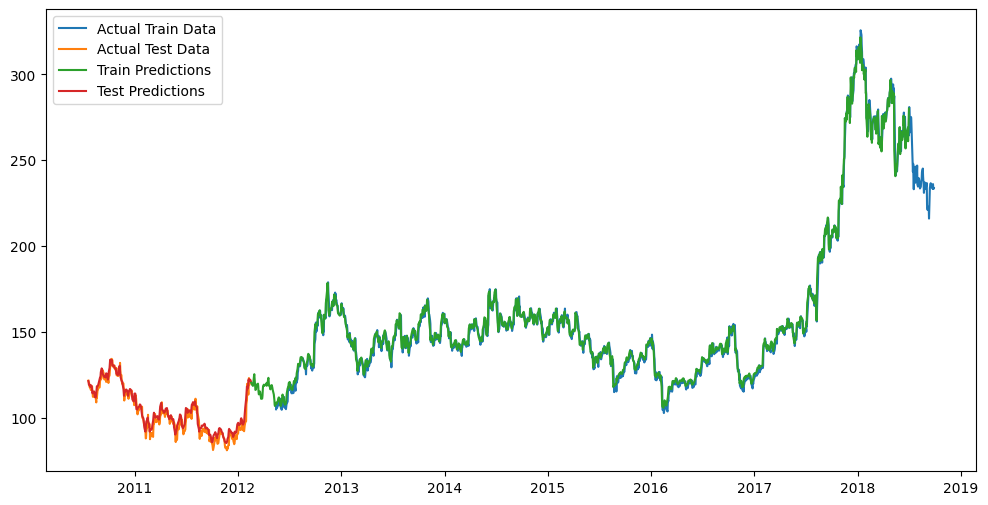

In [15]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot actual train data
plt.plot(df.index[:len(train_predictions)], df['Close'][:len(train_predictions)], label='Actual Train Data')

# Plot actual test data
test_start_index = len(train_predictions) + look_back
test_end_index = test_start_index + len(test_predictions)
plt.plot(df.index[test_start_index:test_end_index], 
         df['Close'][test_start_index:test_end_index], 
         label='Actual Test Data')

# Plot train predictions (shifted appropriately to align with dates)
train_prediction_start_index = look_back
train_prediction_end_index = train_prediction_start_index + len(train_predictions)
plt.plot(df.index[train_prediction_start_index:train_prediction_end_index], 
         train_predictions, 
         label='Train Predictions')

# Plot test predictions (shifted appropriately to align with dates)
test_prediction_start_index = test_start_index
test_prediction_end_index = test_prediction_start_index + len(test_predictions)
plt.plot(df.index[test_prediction_start_index:test_prediction_end_index], 
         test_predictions.flatten(), 
         label='Test Predictions')

plt.legend()
plt.show()
